In [1]:
%load_ext autoreload
%autoreload 2
%env PROJ_LIB=/home/wwymak/anaconda3/envs/solaris/share/proj
%matplotlib inline

env: PROJ_LIB=/home/wwymak/anaconda3/envs/solaris/share/proj


In [52]:
import rasterio

In [42]:

import skimage
import geopandas as gpd
from matplotlib import pyplot as plt
from shapely.ops import cascaded_union
import solaris as sol

from tqdm import tqdm
from skimage.external import tifffile as sktif

# import shapely.wkt
import geopandas as gpd
import numpy as np
import cv2
from functools import partial

from fastai.imports import *
from fastai.vision import *
from fastai.metrics import dice
from fastai.callbacks import *

# from joblib import Parallel, delayed
import torch.nn.functional as F
import torch
import functools, traceback
def gpu_mem_restore(func):
    "Reclaim GPU RAM if CUDA out of memory happened, or execution was interrupted"
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        try:
            return func(*args, **kwargs)
        except:
            type, val, tb = sys.exc_info()
            traceback.clear_frames(tb)
            raise type(val).with_traceback(tb) from None
    return wrapper

os.environ['FASTAI_TB_CLEAR_FRAMES']="1"
from importlib import reload

In [3]:
import sys
sys.path.append("./cresi/src")


In [4]:
data_dir = Path("/media/wwymak/Storage/spacenet_roads")
mumbai = data_dir/"AOI_8_Mumbai"
ms_mumbai = mumbai/"MS"
ps_rgb_mumbai = mumbai/"PS-RGB"

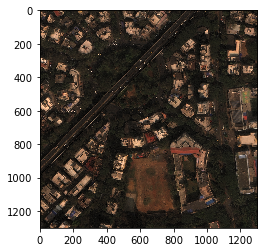

In [16]:
ps_rgb_list = ps_rgb_mumbai.ls()
demo_im = sktif.imread(str(ps_rgb_mumbai/"SN5_roads_train_AOI_8_Mumbai_PS-RGB_chip19.tif"))
plt.imshow(demo_im)

In [19]:
mask_df =pd.read_csv( mumbai / "train_AOI_8_Mumbai_geojson_roads_speed_wkt_weighted.csv")
mask_df.head()

,ImageId,WKT_Pix,length_m,travel_time_s
0,AOI_8_Mumbai_chip0,"LINESTRING (0 32.22116693202406, 192.200136788...",56.809,4.236316
1,AOI_8_Mumbai_chip0,LINESTRING (458.3862400762737 13.2714583603665...,78.722,5.870395
2,AOI_8_Mumbai_chip0,LINESTRING (201.9495008252561 163.568223531357...,43.191,3.220805
3,AOI_8_Mumbai_chip0,"LINESTRING (192.2208984196186 0, 192.342463284...",8.029,0.598732
4,AOI_8_Mumbai_chip0,LINESTRING (728.7709745801985 0.42649332806468...,79.967,5.963236


In [20]:
mask_folder = mumbai / "masks"
mask_folder.mkdir(exist_ok=True)

In [45]:
#using the rgb images for now
num_channels=3
burn_value = 255
# previous spacenet challenge winner found this to be quite effective
road_mask_width = 2

def create_mask(img_id, road_mask_width=4):
    mask_fname = mumbai / "geojson_roads_speed" / f"SN5_roads_train_AOI_8_Mumbai_geojson_roads_speed_{img_id}.geojson"
    outfile = mask_folder / f"{img_id}.png"
    road_mask = np.zeros((1300,1300))
    df = gpd.read_file(mask_fname)
    df.head()
#     try:
    road_mask = sol.vector.mask.road_mask(df,
          shape=(1300,1300),
          width=road_mask_width, meters=True, burn_value=burn_value)
       
        
#     except Exception as e:
#         print(e)
#         pass
    skimage.io.imsave(outfile, road_mask )

In [51]:
# create_mask("chip19", road_mask_width=3)
img_id = "chip19"
mask_fname = mumbai / "geojson_roads_speed" / f"SN5_roads_train_AOI_8_Mumbai_geojson_roads_speed_{img_id}.geojson"
outfile = mask_folder / f"{img_id}.png"
road_mask = np.zeros((1300,1300))
df = gpd.read_file(mask_fname)
df.head()


,OBJECTID,bridge,highway,osm_id,surface,lanes,inferred_speed_mph,inferred_speed_mps,origarea,origlen,partialDec,truncated,geometry
0,1094,None,secondary,683675331.0,paved,2,35.0,15.6464,0.0,0,1,0,LINESTRING (72.85742577561622 19.0243364093124...
1,1097,None,secondary,683675334.0,paved,4,45.0,20.1168,0.0,0,1,0,LINESTRING (72.85692370000004 19.0254491000000...
2,1098,None,secondary,683675335.0,paved,2,35.0,15.6464,0.0,0,1,0,LINESTRING (72.85749752242104 19.0248466656394...
3,1124,None,motorway,683675361.0,paved,2.5,55.0,24.5872,0.0,0,1,0,LINESTRING (72.85645545632443 19.0279899859037...
4,1126,None,motorway,683675362.0,paved,1.5,55.0,24.5872,0.0,0,1,0,LINESTRING (72.85652687643713 19.0279899859037...


In [53]:
test_im =rasterio.open(str(ps_rgb_mumbai/"SN5_roads_train_AOI_8_Mumbai_PS-RGB_chip19.tif"))

In [63]:
test_im =rasterio.open(str(ms_mumbai/"SN5_roads_train_AOI_8_Mumbai_MS_chip19.tif"))

In [64]:
test_im.crs

CRS.from_epsg(4326)

In [61]:
geo_df = sol.vector.polygon.geojson_to_px_gdf(
    str(mumbai / "geojson_roads_speed" / f"SN5_roads_train_AOI_8_Mumbai_geojson_roads_speed_chip19.geojson"),
    str(ps_rgb_mumbai/"SN5_roads_train_AOI_8_Mumbai_PS-RGB_chip19.tif"))

def crs_is_metric(gdf):
    """Check if a GeoDataFrame's CRS is in metric units."""
    units = str(sol.utils.geo.gdf_get_projection_unit(gdf)).strip().lower()
    if units in ['"meter"', '"metre"', "'meter'", "'meter'",
                 'meter', 'metre']:
        return True
    else:
        return False

In [62]:
crs_is_metric(df)

False

In [57]:
buffered_df = buffer_df_geoms(df, width/2., meters=3,
                                  reference_im=test_im, geom_col="geometry",
                                  affine_obj=affine_obj)

CRS.from_epsg(4326)

In [68]:
road_mask = sol.vector.mask.road_mask(df,
          shape=(1300,1300),reference_im=test_im,
          width=10, meters=False, burn_value=burn_value, out_type=int)


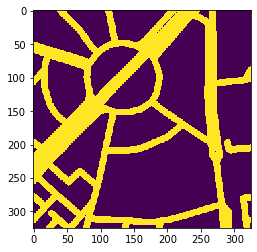

In [69]:
plt.imshow(road_mask)

In [ ]:
def gamma_correction(image, gamma=1.66):
    '''https://www.pyimagesearch.com/2015/10/05/opencv-gamma-correction/'''
    # build a lookup table mapping the pixel values [0, 255] to
    # their adjusted gamma values
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
        for i in np.arange(0, 256)]).astype("uint8")
 
    # apply gamma correction using the lookup table
    return cv2.LUT(image, table)

def calc_rescale(im_file_raw, m, percentiles):
    srcRaster = gdal.Open(im_file_raw)
    for band in range(1, 4):
        b = srcRaster.GetRasterBand(band)
        band_arr_tmp = b.ReadAsArray()
        bmin = np.percentile(band_arr_tmp.flatten(),
                             percentiles[0])
        bmax= np.percentile(band_arr_tmp.flatten(),
                            percentiles[1])
        m[band].append((bmin, bmax))

    # for k, v in m.items():
    #     print(k, np.mean(v, axis=0))
    return m

